# **HW1: COVID-19 Cases Prediction (Regression)**

Methods:
* Training with all data
* `Feature selection` (14 important features)
* DNN architecture (`dimension=91, activation=RReLU`)
* Training (`mini-batch=135, optimizer=SGD, learning rate=0.001`)
* L2 regularization
* Sharing the same normalization mean and std between the training and testing sets.

## **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

In [48]:
tr_path = 'covid.train.csv'  # dim: 2700*94
tt_path = 'covid.test.csv'  # dim: 893*93

!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 31.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 10.3MB/s]


# **Import Some Packages**

In [49]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# **Some Utilities**

設定隨機初始的network參數(weight, bias)

In [50]:
def random_seed_setup(seed):
    # as device
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        return 'cuda'
    else:
        return 'cpu'

def plot_learning_curve(loss_record, title=''):
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

# **Preprocess**

## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

`注意`:Covid19這個class繼承了nn裡面的`Dataset` module.

有解釋能力的features為cli， ili， hh_cmnty_cli， nohh_cmnty_cli， tested_positive

每天都有一筆input feature, 共三天。（第三天少一個tested_positive）

`self.dim`是資料的input dim

In [51]:
class Covid19Dataset(Dataset):
    # Read data & preprocess
    def __init__(self,
                 path,
                 mode='train',
                 normalize='none',
                 target_only=False,
                 norm_mean=None,
                 norm_std=None):
        self.mode = mode

        with open(path, 'r') as fp:     # 標示符'r'表示讀
            data = list(csv.reader(fp))  # list of lists: 一個row為一個list(first list is col names)
            self.data_class = data[0][1:] # [1:] 表示去掉`id`，也就是index那col。
            data = np.array(data[1:])[:, 1:].astype(float) # [:,1:]左邊表示每個row都要，且去掉每個row的index。
            ''' 完整的去掉index和colname的array完成啦！ '''
       
        if not target_only:   # not feature selection
            feats = list(range(93))
        else:
            feats = 40 + np.array([0, 1, 2, 3, 17, 18, 19, 20, 21, 35, 36, 37, 38, 39])

        if mode == 'test':
            data = data[:, feats] # 因為inference也只用得到這些
            self.data = torch.FloatTensor(data) # turn array into tensor
        else:
            target = data[:, -1] # last col, 即正確答案
            data = data[:, feats]
            
            # Splitting into train/validation
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0] # len(data) would be number of rows.
            elif mode == 'dev':
                indices = list(range(893))
            else:
                indices = list(range(len(data)))
                # only when mode == 'train_all' (i.e., using all data for training)
            data = data[indices]
            target = target[indices]
            self.data = torch.FloatTensor(data)
            self.target = torch.FloatTensor(target)
        
       
        self.norm_mean = None
        self.norm_std = None

        if normalize == 'self':
            '''假如有n個col(ft)，mean/std(of ft)就是n個元素的一維向量，unsqueeze(0)會幫忙轉為1*n的2維向量'''
            self.norm_mean = self.data.mean(dim=0).unsqueeze(0)
            self.norm_std = self.data.std(dim=0).unsqueeze(0)
            self.data = (self.data - self.norm_mean) / self.norm_std
        if normalize == 'given' and (norm_mean is not None) and (norm_std is not None):
            self.data = (self.data - norm_mean) / norm_std
            # we will Sharing the same normalization mean and std between the training and testing sets

        self.dim = self.data.shape[1] # number of col/ft, input dim of model

        print('Finished reading the {} set of the Covid19 Dataset ({} samples found, each dim = {})'
              .format(mode, self.data.shape[0], self.data.shape[1]))

    # Returns one sample at a time
    def __getitem__(self, index):
        if self.mode in ['train', 'dev', 'train_all']:
            return self.data[index], self.target[index]
        # in Training loop, it would be i, (x,y) in enumerate(dataloader)
        else:
            return self.data[index]
    # Returns the size of the dataset
    def __len__(self):
        return len(self.data)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [52]:
def prep_dataloader(tr_path, tt_path, batch_size, n_jobs=0, target_only=False):
    tr_dataset = Covid19Dataset(
        tr_path, mode='train_all',
        normalize='self', 
        target_only=target_only)

    dv_dataset = Covid19Dataset(
        tr_path, mode='dev',
        normalize='given', 
        target_only=target_only,
        norm_mean=tr_dataset.norm_mean,
        norm_std=tr_dataset.norm_std)

    tt_dataset = Covid19Dataset(
        tt_path, mode='test',
        normalize='given',
        target_only=target_only,
        norm_mean=tr_dataset.norm_mean,
        norm_std=tr_dataset.norm_std)
    
    tr_dataloader = DataLoader(  # 這邊要注意的參數是shuffle， batch_size 以及num_worker(效能)
        tr_dataset, batch_size,
        shuffle=True, drop_last=False,
        num_workers=n_jobs, pin_memory=True)
    
    dv_dataloader = DataLoader(
        dv_dataset, batch_size,
        shuffle=False, drop_last=False,
        num_workers=n_jobs, pin_memory=True)

    tt_dataloader = DataLoader(
        tt_dataset, batch_size,
        shuffle=False, drop_last=False,
        num_workers=n_jobs, pin_memory=True)
    
    return tr_dataloader, dv_dataloader, tt_dataloader

# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.

`super物件`在member function名稱重複時使用，用來處理多重繼承時的適用順序判定。
* 此處的應用為 `覆寫`並設計想要的network structure

[L2 regularization](https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/) is also known as `weight decay` as it forces the weights to decay towards zero by adding panelty in loss function.


In [53]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim, l2_reg=0.):
        '''Initialize your model & define layers'''
        super(NeuralNet, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, 91),
            nn.RReLU(),  
            nn.Linear(91, 1)
        )
        self.criterion = nn.MSELoss(reduction='mean')
        self.l2_reg = l2_reg

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1) # make sure that output dim = 1

    def cal_loss(self, pred, target, is_train=True):
        total_loss = 0
        mse_loss = self.criterion(pred, target)
        total_loss += mse_loss
        # L2 regularization, with hyperparameter lambda.
        if is_train and self.l2_reg > 0.:
            reg_loss = 0
            for param in self.parameters():
                reg_loss += torch.norm(param, p=2) # L`2`, p is the order of norm.
            total_loss += reg_loss * self.l2_reg
        
        return total_loss, mse_loss

# **Train/Dev/Test**

## **Training**

In [71]:
def train(tr_set, dv_set, model, config, device):
    n_epochs = config['n_epochs']
    '''getattr 可從torch.optim這個物件中取出特定optimizer（的屬性值）。'''
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    loss_record = {'train': []}
    epoch = 0
    while epoch < n_epochs:
        model.train()
        '''i would be the index, (x,y) is the data <-> target pair in form of tensor'''
        for i, (x, y) in enumerate(tr_set):
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            pred = model(x)
            total_loss, mse_loss = model.cal_loss(pred, y, is_train=True)
            total_loss.backward() # cal gradient
            optimizer.step() # 更新參數
            loss_record['train'].append(total_loss.detach().cpu().item())

        dev_mse = dev(dv_set, model, device)
        
        print('Saving model (epoch = {:3d}), validation_loss would be {:.2f} !'
              .format(epoch + 1, dev_mse))
        torch.save(model.state_dict(), config['save_path'])
        # 可考慮，遇到loss最低的再存
        epoch += 1

    print('Finished training after {} epochs'.format(epoch))
    return loss_record


def dev(dv_set, model, device):
    model.eval()
    total_loss = 0
    for x, y in dv_set:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
            _, mse_loss = model.cal_loss(pred, y, is_train=False) 
        total_loss += mse_loss.detach().cpu().item() * len(x)
    total_loss = total_loss / len(dv_set.dataset)
    # 這邊的total loss有點混舀，注意即可
    return total_loss

## **Testing**
remember to concatenate all predictions and convert to a numpy array

In [55]:
def test(tt_set, model, device):
    model.eval()                                
    preds = []
    for x in tt_set:                           
        x = x.to(device)                       
        with torch.no_grad():                  
            pred = model(x)                    
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()    
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [56]:
device = random_seed_setup(42097)
os.makedirs('models', exist_ok=True)  # create a file
target_only = True

config = {
    'n_epochs': 80,                  
    'batch_size': 135,               
    'optimizer': 'SGD',              
    'optim_hparas': {                
        'lr': 0.001,                 
        'momentum': 0.9             
    },
    'early_stop': 20,                # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth' 
}

# **Load data and model**

In [73]:
tr_set, dv_set, tt_set = prep_dataloader(
    tr_path, tt_path, config['batch_size'], 
    target_only=target_only)

Finished reading the train_all set of the Covid19 Dataset (2700 samples found, each dim = 14)
Finished reading the dev set of the Covid19 Dataset (893 samples found, each dim = 14)
Finished reading the test set of the Covid19 Dataset (893 samples found, each dim = 14)


In [65]:
model = NeuralNet(tr_set.dataset.dim, 0.001).to(device)  # Construct model and move to device

# **Start Training!**

In [72]:
model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =   1), validation_loss would be 1.09 !
Saving model (epoch =   2), validation_loss would be 1.07 !
Saving model (epoch =   3), validation_loss would be 1.07 !
Saving model (epoch =   4), validation_loss would be 1.08 !
Saving model (epoch =   5), validation_loss would be 1.07 !
Saving model (epoch =   6), validation_loss would be 1.08 !
Saving model (epoch =   7), validation_loss would be 1.07 !
Saving model (epoch =   8), validation_loss would be 1.09 !
Saving model (epoch =   9), validation_loss would be 1.07 !
Saving model (epoch =  10), validation_loss would be 1.09 !
Saving model (epoch =  11), validation_loss would be 1.08 !
Saving model (epoch =  12), validation_loss would be 1.08 !
Saving model (epoch =  13), validation_loss would be 1.07 !
Saving model (epoch =  14), validation_loss would be 1.08 !
Saving model (epoch =  15), validation_loss would be 1.08 !
Saving model (epoch =  16), validation_loss would be 1.09 !
Saving model (epoch =  17), validation_l

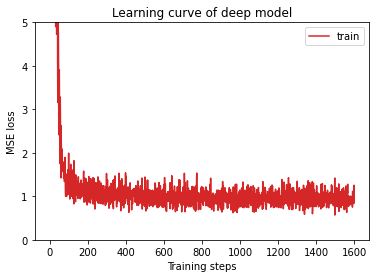

In [60]:
plot_learning_curve(model_loss_record, title='deep model')

In [61]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)

<All keys matched successfully>

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [62]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  
save_pred(preds, 'pred.csv')         

Saving results to pred.csv


# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author.